In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import seaborn as sns

# BNN Modules
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
import torch.nn as nn
from sklearn.model_selection import train_test_split

from pyro.infer import MCMC, NUTS

from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO, Predictive
from tqdm.auto import trange, tqdm

from tqdm.auto import trange


/usr/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class BNN(PyroModule):
    def __init__(self, in_dim=2, out_dim=1, hid_dim=10, n_hid_layers=5, prior_scale=5.):
        super().__init__()

        self.activation = nn.Tanh()  # could also be ReLU or LeakyReLU
        assert in_dim > 0 and out_dim > 0 and hid_dim > 0 and n_hid_layers > 0  # make sure the dimensions are valid

        # Define the layer sizes and the PyroModule layer list
        self.layer_sizes = [in_dim] + n_hid_layers * [hid_dim] + [out_dim]
        layer_list = [PyroModule[nn.Linear](self.layer_sizes[idx - 1], self.layer_sizes[idx]) for idx in
                      range(1, len(self.layer_sizes))]
        self.layers = PyroModule[torch.nn.ModuleList](layer_list)

        for layer_idx, layer in enumerate(self.layers):
            layer.weight = PyroSample(dist.Normal(0., prior_scale * np.sqrt(2 / self.layer_sizes[layer_idx])).expand(
                [self.layer_sizes[layer_idx + 1], self.layer_sizes[layer_idx]]).to_event(2))
            layer.bias = PyroSample(dist.Normal(0., prior_scale).expand([self.layer_sizes[layer_idx + 1]]).to_event(1))

    def forward(self, x, y=None):
        x = self.activation(self.layers[0](x))  # input --> hidden
        for layer in self.layers[1:-1]:
            x = self.activation(layer(x))  # hidden --> hidden
        mu = self.layers[-1](x).squeeze()  # hidden --> output
        sigma = pyro.sample("sigma", dist.Gamma(1, 2))  # infer the response noise

        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, sigma * sigma), obs=y)
        return mu

In [3]:
pyro.clear_param_store()
#optimizer = pyro.optim.Adam({"lr": 0.0001})
#svi = SVI(model, mean_field_guide, optimizer, loss=Trace_ELBO())

In [4]:
with open("result.pkl", "rb") as g:
    model, mean_field_guide, svi = pickle.load(g)

In [5]:
def get_mean_std(preds):
	y_pred = torch.exp(preds['obs']).T.detach().numpy().mean(axis=1)
	y_std = torch.exp(preds['obs']).T.detach().numpy().std(axis=1)
	return y_pred,y_std

In [6]:
X_trial = np.zeros([101,2])
X_trial[:,0] = 10**np.linspace(0,2.5,101)
X_trial[:,1] = 100
X_trial = torch.tensor(X_trial, dtype=torch.float32)
predictive = Predictive(model, guide=mean_field_guide, num_samples=2000)
preds = predictive(X_trial)
PGA100,PGA100s = get_mean_std(preds)

In [7]:
X_trial = np.zeros([101,2])
X_trial[:,0] = 10**np.linspace(0,2.5,101)
X_trial[:,1] = 400
X_trial = torch.tensor(X_trial, dtype=torch.float32)
predictive = Predictive(model, guide=mean_field_guide, num_samples=2000)
preds = predictive(X_trial)
PGA400,PGA400s = get_mean_std(preds)

In [8]:
X_trial = np.zeros([101,2])
X_trial[:,0] = 10**np.linspace(0,2.5,101)
X_trial[:,1] = 700
X_trial = torch.tensor(X_trial, dtype=torch.float32)
predictive = Predictive(model, guide=mean_field_guide, num_samples=2000)
preds = predictive(X_trial)
PGA700,PGA700s = get_mean_std(preds)

In [9]:
X_trial = np.zeros([101,2])
X_trial[:,0] = 10**np.linspace(0,2.5,101)
X_trial[:,1] = 1000
X_trial = torch.tensor(X_trial, dtype=torch.float32)
predictive = Predictive(model, guide=mean_field_guide, num_samples=2000)
preds = predictive(X_trial)
PGA1000,PGA1000s = get_mean_std(preds)

In [11]:
ground_motion = pd.read_pickle("data/processed_ground_motion_PGA.pkl")
interest_index = (ground_motion['Earthquake Magnitude'] > 6.0) & (ground_motion['Earthquake Magnitude'] < 7.0)
ground_motion2 = ground_motion[interest_index]

/usr/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/usr/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


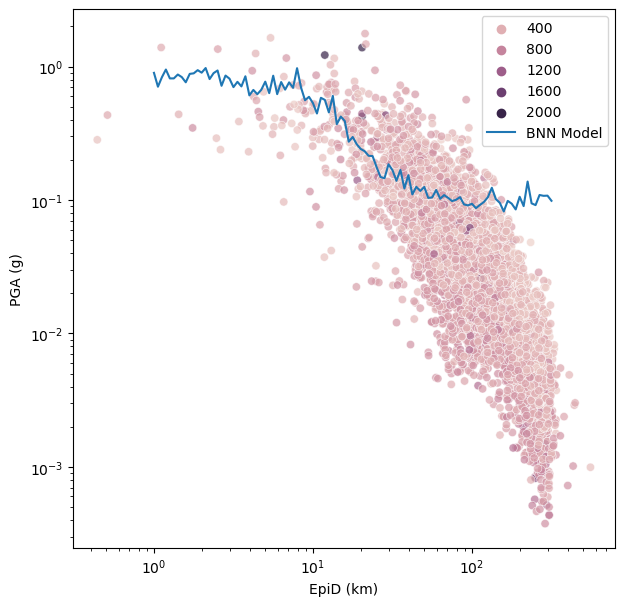

In [21]:
f, ax = plt.subplots(figsize=(7, 7))
ax.set(xscale="log", yscale="log")
sns.scatterplot(data=ground_motion2, x="EpiD (km)", y="PGA (g)",hue="Vs30 (m/s) selected for analysis", alpha=0.7)
ax.set(xscale="log", yscale="log")
plt.plot(10**np.linspace(0,2.5,101),PGA100, label='BNN Model')
#plt.fill_between(10**np.linspace(0,2.5,101), PGA100-PGA100s, PGA100+PGA100s)
plt.legend()